<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Metrics" data-toc-modified-id="Metrics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Metrics</a></span></li><li><span><a href="#Example-data-on-2021-04-24" data-toc-modified-id="Example-data-on-2021-04-24-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example data on 2021-04-24</a></span><ul class="toc-item"><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-related-metrics" data-toc-modified-id="Shared-control-related-metrics-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Shared control-related metrics</a></span></li></ul></li><li><span><a href="#Example-data-on-2021-04-10" data-toc-modified-id="Example-data-on-2021-04-10-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Example data on 2021-04-10</a></span><ul class="toc-item"><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-related-metrics" data-toc-modified-id="Shared-control-related-metrics-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Shared control-related metrics</a></span></li></ul></li><li><span><a href="#Comparison-between-0410-and-0424" data-toc-modified-id="Comparison-between-0410-and-0424-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparison between 0410 and 0424</a></span><ul class="toc-item"><li><span><a href="#Crowd-related-metrics" data-toc-modified-id="Crowd-related-metrics-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Crowd-related metrics</a></span></li><li><span><a href="#Path-Efficiency-related-metrics" data-toc-modified-id="Path-Efficiency-related-metrics-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Path Efficiency-related metrics</a></span></li><li><span><a href="#Shared-control-related-metrics" data-toc-modified-id="Shared-control-related-metrics-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Shared control-related metrics</a></span></li></ul></li></ul></div>

# Crowd navigation evaluation

> Analysis of different control methods on different datas

In [1]:
import math
import collections
import urllib.request
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.3})

import sys, os, fnmatch
# Importing Metrics Functions:
# sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'qolo'))

from crowd_evaluation import *
from crowdbot_data import CrowdBotData, CrowdBotDatabase
from notebook_util import walk, violinplot, categorical_plot

# %matplotlib inline

In [2]:
qolo_dataset = CrowdBotData()

bagbase = qolo_dataset.bagbase_dir
outbase = qolo_dataset.outbase_dir

print("rosbag database:", bagbase)
print(os.listdir(bagbase))
print()
print("output database:", outbase)
print(os.listdir(outbase))

control_types = ['mds', 'rds', 'shared_control']

rosbag database: /hdd/data_qolo/crowd_qolo_recordings/
['0325_rds', '0410_mds', '0410_rds', '0410_shared_control', '0424_mds', '0424_rds', '0424_shared_control', 'MDS', 'RDS', 'readme.md', 'shared_control']

output database: /hdd/data_qolo/crowdbot_data_analysis/
['0410_mds_processed', '0410_rds_issues', '0410_rds_processed', '0410_shared_control_processed', '0424_mds_processed', '0424_rds_processed', '0424_shared_control_processed', 'apply_low_pass', 'MDS_processed', 'shared_test_processed', 'test_processed']


In [3]:
#!sh data_export_pipeline.sh -e=py38cuda110 -t=shared_test

## Metrics

1. Crowd-related

    1. (Main) Crowd Density (within an area of 10m around the robot):

    2. (Main) Minimal distance to pedestrians: mean+SD: 

    3. Normalized proximity to surrounding pedestrians : SD(d1..dn) / avg(d1...dn)
    
2. Path efficiency-related

    1. Relative time to goal (normalized by the goal distance)
    2. Relative path length (normalized by the goal distance in straight line): 

3. Control-related

    1. Agreement
    2. Fluency
    3. Relative Jerk (smoothness of the path as added sum of linear and angular jerk)

## Example data on 2021-04-24

In [4]:
example_date = '0424'
eval_dirs = []
for root, dirs, files in walk(bagbase, topdown=False, maxdepth=1):
    for dir in dirs:
        if (example_date in dir):
            eval_dirs.append(dir)
            print("{}/ is available!".format(dir))

0424_mds/ is available!
0424_rds/ is available!
0424_shared_control/ is available!


In [5]:
# for eval_dir in eval_dirs:
eval_dir = eval_dirs[0]
print("Reading results from {}".format(eval_dir))

# new a CrowdBotDatabase() instance
eval_database = CrowdBotDatabase(classdir=eval_dir)

Reading results from 0424_mds


In [6]:
print("Available sequences in {}:\n{}".format(eval_dir, eval_database.seqs))

Available sequences in 0424_mds:
['2021-04-24-12-04-04', '2021-04-24-12-07-57', '2021-04-24-12-10-45', '2021-04-24-12-54-04', '2021-04-24-12-56-59', '2021-04-24-13-03-39']


### Crowd-related metrics

- eval code

In [7]:
crowd_metrics = ('avg_crowd_density5', 
                 'max_crowd_density5', 
                 'avg_crowd_density10', 
                 'avg_min_dist',
                 'normalized_proximity',
                 'path_lenth2goal',
                 'min_dist2goal',
                )

frames = []

for eval_dir in eval_dirs:

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    m_dict = {'seq': eval_database.seqs}
    m_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    m_dict.update({k: [] for k in crowd_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        crowd_eval_npy = os.path.join(eval_res_dir, seq + "_crowd_eval.npy")
        crowd_eval_dict = np.load(
            crowd_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(crowd_metrics):
            m_dict[crowd_metrics[iidx]].append(crowd_eval_dict[val])

    crowd_df = pd.DataFrame(m_dict)
    crowd_df.columns = ['seq', 'control_type'] + list(crowd_metrics)
    
    # Filter path_lenth2goal less than 5 meter
    crowd_df = crowd_df[crowd_df.path_lenth2goal >= 5.0]

    frames.append(crowd_df)

crowd_metrics_df = pd.concat(frames, ignore_index=True)

Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


- choose specific control type from final dataframe

In [8]:
crowd_metrics_df
# crowd_metrics_df[crowd_metrics_df.control_type == 'shared_control']

,seq,control_type,avg_crowd_density5,max_crowd_density5,avg_crowd_density10,avg_min_dist,normalized_proximity,path_lenth2goal,min_dist2goal
0,2021-04-24-12-04-04,mds,0.120290,0.267380,0.061124,1.004118,0.0,20.599373,4.639460
1,2021-04-24-12-07-57,mds,0.093233,0.305577,0.046961,1.497923,0.0,31.204075,0.442452
2,2021-04-24-12-10-45,mds,0.149362,0.343775,0.069602,1.020987,0.0,25.521812,3.660897
3,2021-04-24-12-54-04,mds,0.114009,0.318310,0.062583,1.195786,0.0,29.649303,3.565907
4,2021-04-24-12-56-59,mds,0.137841,0.318310,0.068062,1.028432,0.0,20.827414,8.150437
5,2021-04-24-13-03-39,mds,0.150969,0.254648,0.061873,1.107777,0.0,8.624434,13.485230
6,2021-04-24-11-20-18,rds,0.160733,0.343775,0.070133,0.970209,0.0,7.429669,14.049798
7,2021-04-24-11-23-43,rds,0.125135,0.280113,0.063976,1.063080,0.0,22.477041,9.416976
8,2021-04-24-11-35-54,rds,0.122445,0.381972,0.055816,1.215617,0.0,22.128941,0.024584
9,2021-04-24-11-40-33,rds,0.161121,0.356507,0.074358,0.782049,0.0,23.956970,2.916744


- calculate std and mean according to `control_type`

In [9]:
for ctrl in control_types:
    print("###", ctrl)
    print("# mean")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
avg_crowd_density5       0.127617
max_crowd_density5       0.301333
avg_crowd_density10      0.061701
avg_min_dist             1.142504
normalized_proximity     0.000000
path_lenth2goal         22.737734
min_dist2goal            5.657397
dtype: float64
# std
avg_crowd_density5      0.022556
max_crowd_density5      0.033847
avg_crowd_density10     0.008016
avg_min_dist            0.188307
normalized_proximity    0.000000
path_lenth2goal         8.180550
min_dist2goal           4.562508
dtype: float64

### rds
# mean
avg_crowd_density5       0.146772
max_crowd_density5       0.338318
avg_crowd_density10      0.067548
avg_min_dist             0.934207
normalized_proximity     0.000000
path_lenth2goal         18.863827
min_dist2goal            6.187122
dtype: float64
# std
avg_crowd_density5      0.017005
max_crowd_density5      0.042773
avg_crowd_density10     0.006204
avg_min_dist            0.157859
normalized_proximity    0.000000
path_lenth2goal         6.509468
min_dis

- using sns.violinplot/boxplot

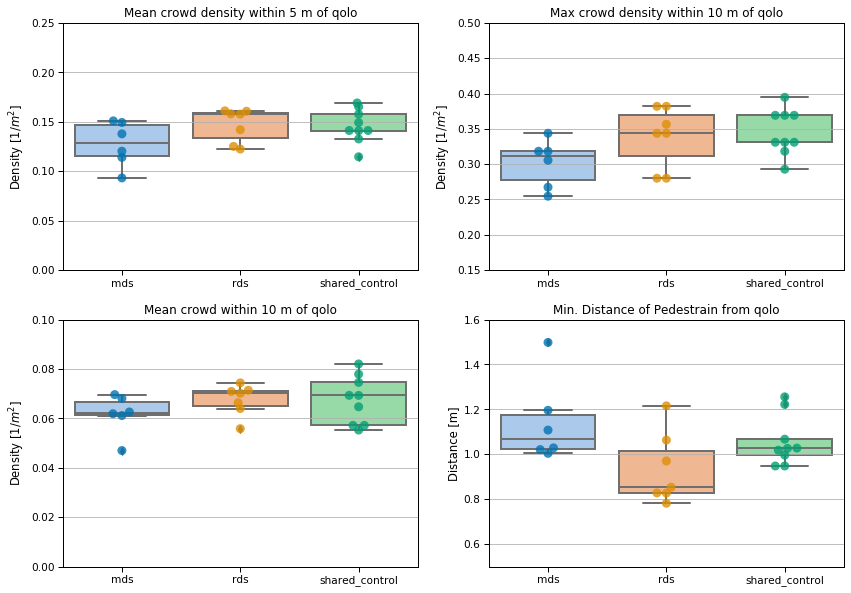

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categorical_plot(
    axes=axes[0,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density5',
    catogory='control_type',
    title='Mean crowd density within 5 m of qolo',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.00, 0.25],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)
categorical_plot(
    axes=axes[0,1],
    df=crowd_metrics_df,
    metric='max_crowd_density5',
    catogory='control_type',
    title='Max crowd density within 10 m of qolo',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.15, 0.50],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

categorical_plot(
    axes=axes[1,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density10',
    catogory='control_type',
    title='Mean crowd within 10 m of qolo',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.1],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

categorical_plot(
    axes=axes[1,1],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    catogory='control_type',
    title='Min. Distance of Pedestrain from qolo',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 1.6],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

plt.show()

In [11]:
plt.close()

### Path Efficiency-related metrics

- eval code

In [12]:
path_metrics = ('rel_duration2goal', 
                'rel_path_length2goal', 
                'path_lenth2goal',
                'duration2goal',
                'min_dist2goal',
               )

path_frames = []

for ii, eval_dir in enumerate(eval_dirs):

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    pm_dict = {'seq': eval_database.seqs}
    pm_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    pm_dict.update({k: [] for k in path_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        qolo_eval_npy = os.path.join(eval_res_dir, seq + "_qolo_eval.npy")
        qolo_eval_dict = np.load(
            qolo_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(path_metrics):
            pm_dict[path_metrics[iidx]].append(qolo_eval_dict[val])
            # print(iidx, val, path_metrics[iidx])
    # print(pm_dict.keys())
        
    path_df = pd.DataFrame(pm_dict)
    path_df.columns = ['seq', 'control_type'] + list(path_metrics)
    
    # Filter path_lenth2goal less than 5 meter
    path_df = path_df[path_df.path_lenth2goal >= 5.0]

    path_frames.append(path_df)
    
path_metrics_df = pd.concat(path_frames, ignore_index=True)
path_metrics_df.head()

Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


,seq,control_type,rel_duration2goal,rel_path_length2goal,path_lenth2goal,duration2goal,min_dist2goal
0,2021-04-24-12-04-04,mds,0.235035,1.344082,20.599373,81.509443,4.639460
1,2021-04-24-12-07-57,mds,0.442688,1.566391,31.204075,56.250129,0.442452
2,2021-04-24-12-10-45,mds,0.292015,1.490112,25.521812,73.315837,3.660897
3,2021-04-24-12-54-04,mds,0.258089,1.803221,29.649303,79.635424,3.565907
4,2021-04-24-12-56-59,mds,0.190793,1.797216,20.827414,75.924780,8.150437


In [13]:
for ctrl in control_types:
    print("###", ctrl)
    print("# mean")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
rel_duration2goal        0.272669
rel_path_length2goal     1.544950
path_lenth2goal         22.737734
duration2goal           67.620699
min_dist2goal            5.657397
dtype: float64
# std
rel_duration2goal        0.090187
rel_path_length2goal     0.223823
path_lenth2goal          8.180550
duration2goal           16.625371
min_dist2goal            4.562508
dtype: float64

### rds
# mean
rel_duration2goal        0.348324
rel_path_length2goal     1.338266
path_lenth2goal         18.863827
duration2goal           54.050655
min_dist2goal            6.187122
dtype: float64
# std
rel_duration2goal        0.152596
rel_path_length2goal     0.264261
path_lenth2goal          6.509468
duration2goal           16.007709
min_dist2goal            4.606837
dtype: float64

### shared_control
# mean
rel_duration2goal        0.256765
rel_path_length2goal     1.547150
path_lenth2goal         26.270361
duration2goal           62.134836
min_dist2goal            6.202300
dtype: float64
# std

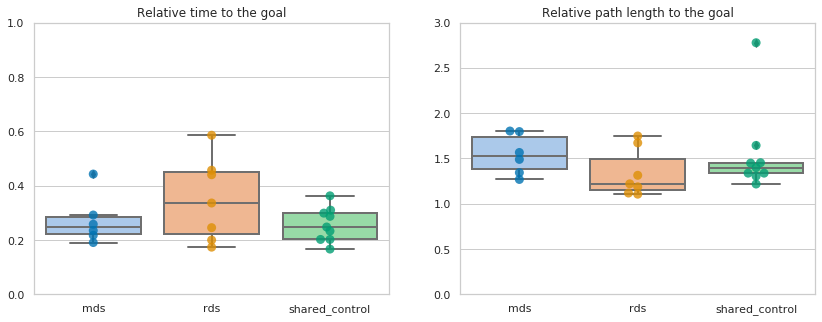

In [14]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(14, 5))

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    catogory='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    catogory='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

plt.show()

In [15]:
plt.close()

### Shared control-related metrics

In [16]:
control_metrics = ('rel_jerk', 
                   'avg_fluency',  
                   'contribution', 
                   'avg_agreement',
                   'path_lenth2goal',
                   'min_dist2goal',
                   )

control_frames = []

for ii, eval_dir in enumerate(eval_dirs):

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    cm_dict = {'seq': eval_database.seqs}
    cm_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    cm_dict.update({k: [] for k in control_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        qolo_eval_npy = os.path.join(eval_res_dir, seq + "_qolo_eval.npy")
        qolo_eval_dict = np.load(
            qolo_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(control_metrics):
            cm_dict[control_metrics[iidx]].append(qolo_eval_dict[val])
        
    # print(cm_dict)
    control_df = pd.DataFrame(cm_dict)
    control_df.columns = ['seq', 'control_type'] + list(control_metrics)
    
    # Filter path_lenth2goal less than 5 meter
    control_df = control_df[control_df.path_lenth2goal >= 5.0]

    control_frames.append(control_df)
    
control_metrics_df = pd.concat(control_frames, ignore_index=True)

Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


In [17]:
# control_metrics_df.head()
control_metrics_df

,seq,control_type,rel_jerk,avg_fluency,contribution,avg_agreement,path_lenth2goal,min_dist2goal
0,2021-04-24-12-04-04,mds,-0.011925,0.965954,0.558885,0.699796,20.599373,4.639460
1,2021-04-24-12-07-57,mds,2.428843,0.973126,0.655099,0.673129,31.204075,0.442452
2,2021-04-24-12-10-45,mds,0.804337,0.965520,0.603494,0.752797,25.521812,3.660897
3,2021-04-24-12-54-04,mds,0.005470,0.967496,0.639752,0.726332,29.649303,3.565907
4,2021-04-24-12-56-59,mds,0.001597,0.969001,0.540386,0.739734,20.827414,8.150437
5,2021-04-24-13-03-39,mds,0.002090,0.977023,0.427573,0.673465,8.624434,13.485230
6,2021-04-24-11-20-18,rds,15.067107,0.985981,0.863063,0.713042,7.429669,14.049798
7,2021-04-24-11-23-43,rds,0.004716,0.994723,0.918440,0.727895,22.477041,9.416976
8,2021-04-24-11-35-54,rds,-0.140303,0.996114,1.021579,0.724589,22.128941,0.024584
9,2021-04-24-11-40-33,rds,0.028805,0.995468,1.109626,0.697580,23.956970,2.916744


In [18]:
# for ctrl in control_types:
#     print("###", ctrl)
#     print("# mean")
#     print(control_df[control_df.control_type == ctrl].mean(numeric_only=True))
#     print("# std")
#     print(control_df[control_df.control_type == ctrl].std(numeric_only=True))
#     print()

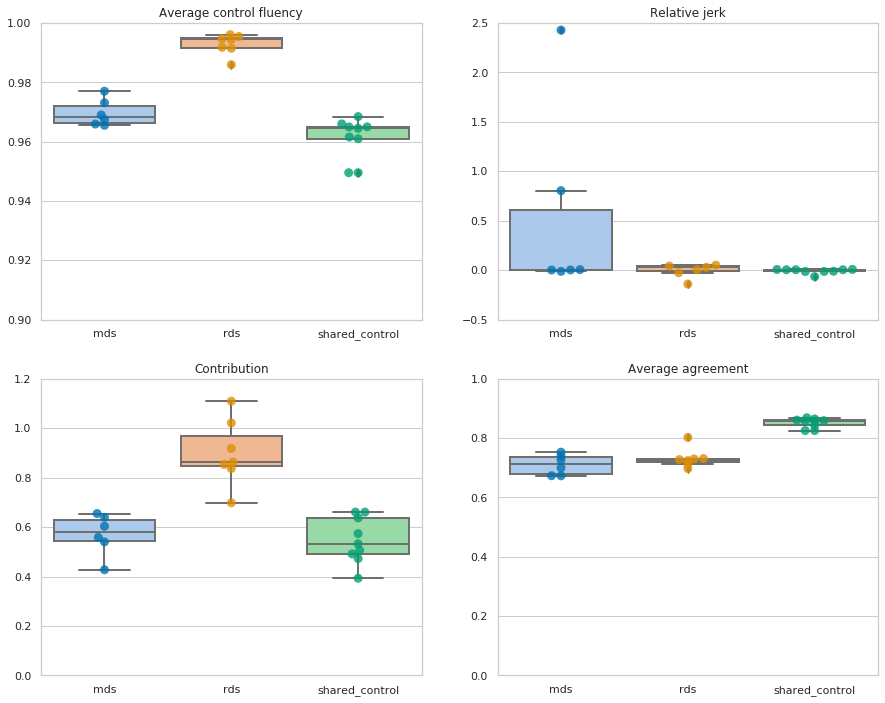

In [19]:
control_fig, control_axes = plt.subplots(2, 2, figsize=(15, 12))

categorical_plot(
    axes=control_axes[0,0],
    df=control_metrics_df,
    metric='avg_fluency',
    catogory='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.90, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[0,1],
    df=control_metrics_df,
    metric='rel_jerk',
    catogory='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[-0.5, 2.5],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,0],
    df=control_metrics_df,
    metric='contribution',
    catogory='control_type',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.2],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,1],
    df=control_metrics_df,
    metric='avg_agreement',
    catogory='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

plt.show()

In [20]:
plt.close()

## Example data on 2021-04-10

In [21]:
example_date = '0410'
eval_dirs = []
for root, dirs, files in walk(bagbase, topdown=False, maxdepth=1):
    for dir in dirs:
        if (example_date in dir):
            eval_dirs.append(dir)
            print("{}/ is available!".format(dir))

0410_mds/ is available!
0410_rds/ is available!
0410_shared_control/ is available!


### Crowd-related metrics

In [22]:
crowd_metrics = ('avg_crowd_density5', 
                 'max_crowd_density5', 
                 'avg_crowd_density10', 
                 'avg_min_dist',
                 'normalized_proximity',
                 'path_lenth2goal',
                 'min_dist2goal',
                )

frames = []

for eval_dir in eval_dirs:

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    m_dict = {'seq': eval_database.seqs}
    m_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    m_dict.update({k: [] for k in crowd_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        crowd_eval_npy = os.path.join(eval_res_dir, seq + "_crowd_eval.npy")
        crowd_eval_dict = np.load(
            crowd_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(crowd_metrics):
            m_dict[crowd_metrics[iidx]].append(crowd_eval_dict[val])

    crowd_df = pd.DataFrame(m_dict)
    crowd_df.columns = ['seq', 'control_type'] + list(crowd_metrics)
    
    # Filter path_lenth2goal less than 5 meter
    crowd_df = crowd_df[crowd_df.path_lenth2goal >= 5.0]

    frames.append(crowd_df)

crowd_metrics_df = pd.concat(frames, ignore_index=True)

Reading results from 0410_mds
Reading results from 0410_rds
Reading results from 0410_shared_control


In [23]:
for ctrl in control_types:
    print("###", ctrl)
    print("# mean")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
avg_crowd_density5       0.110323
max_crowd_density5       0.250828
avg_crowd_density10      0.066573
avg_min_dist             1.182001
normalized_proximity     0.000000
path_lenth2goal         20.774523
min_dist2goal            4.344192
dtype: float64
# std
avg_crowd_density5      0.012525
max_crowd_density5      0.028184
avg_crowd_density10     0.006799
avg_min_dist            0.156473
normalized_proximity    0.000000
path_lenth2goal         4.389658
min_dist2goal           3.767686
dtype: float64

### rds
# mean
avg_crowd_density5       0.116271
max_crowd_density5       0.255627
avg_crowd_density10      0.066073
avg_min_dist             1.069080
normalized_proximity     0.000000
path_lenth2goal         20.927706
min_dist2goal            7.249095
dtype: float64
# std
avg_crowd_density5       0.013224
max_crowd_density5       0.032236
avg_crowd_density10      0.005068
avg_min_dist             0.196563
normalized_proximity     0.000000
path_lenth2goal          6.178221
m

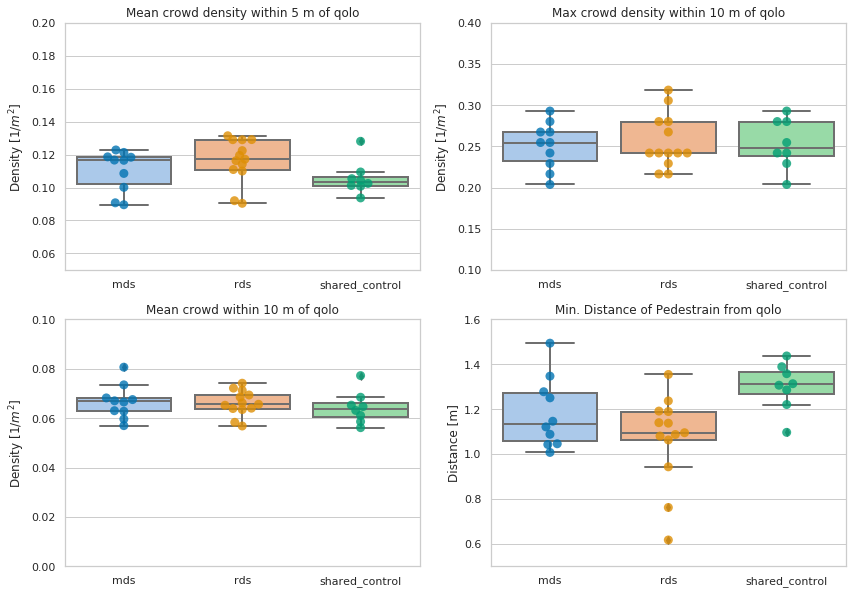

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categorical_plot(
    axes=axes[0,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density5',
    catogory='control_type',
    title='Mean crowd density within 5 m of qolo',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.05, 0.20],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)
categorical_plot(
    axes=axes[0,1],
    df=crowd_metrics_df,
    metric='max_crowd_density5',
    catogory='control_type',
    title='Max crowd density within 10 m of qolo',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.10, 0.40],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

categorical_plot(
    axes=axes[1,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density10',
    catogory='control_type',
    title='Mean crowd within 10 m of qolo',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.1],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

categorical_plot(
    axes=axes[1,1],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    catogory='control_type',
    title='Min. Distance of Pedestrain from qolo',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 1.6],
    kind='box',
    # group='goal_reached',
    # lgd_labels=['Not reached', 'Reached'],
)

plt.show()

In [25]:
plt.close()

### Path Efficiency-related metrics

In [26]:
path_metrics = ('rel_duration2goal', 
                'rel_path_length2goal', 
                'path_lenth2goal',
                'duration2goal',
                'min_dist2goal',
               )

path_frames = []

for ii, eval_dir in enumerate(eval_dirs):

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    pm_dict = {'seq': eval_database.seqs}
    pm_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    pm_dict.update({k: [] for k in path_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        qolo_eval_npy = os.path.join(eval_res_dir, seq + "_qolo_eval.npy")
        qolo_eval_dict = np.load(
            qolo_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(path_metrics):
            pm_dict[path_metrics[iidx]].append(qolo_eval_dict[val])
            # print(iidx, val, path_metrics[iidx])
    # print(pm_dict.keys())
        
    path_df = pd.DataFrame(pm_dict)
    path_df.columns = ['seq', 'control_type'] + list(path_metrics)
    
    # Filter path_lenth2goal less than 5 meter
    path_df = path_df[path_df.path_lenth2goal >= 5.0]

    path_frames.append(path_df)
    
path_metrics_df = pd.concat(path_frames, ignore_index=True)
path_metrics_df.head()

Reading results from 0410_mds
Reading results from 0410_rds
Reading results from 0410_shared_control


,seq,control_type,rel_duration2goal,rel_path_length2goal,path_lenth2goal,duration2goal,min_dist2goal
0,2021-04-10-11-28-10,mds,0.222623,1.223539,18.637169,85.526728,4.849555
1,2021-04-10-11-30-57,mds,0.368713,1.307549,20.382484,52.847092,4.291679
2,2021-04-10-11-33-46,mds,0.470863,1.109684,18.319101,43.824839,3.306577
3,2021-04-10-11-36-41,mds,0.208948,1.356465,19.928324,87.888817,5.038430
4,2021-04-10-11-54-34,mds,0.129141,1.646356,10.646132,62.591449,13.975889


In [27]:
for ctrl in control_types:
    print("###", ctrl)
    print("# mean")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(path_metrics_df[path_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
rel_duration2goal        0.303398
rel_path_length2goal     1.320937
path_lenth2goal         20.774523
duration2goal           68.938941
min_dist2goal            4.344192
dtype: float64
# std
rel_duration2goal        0.099240
rel_path_length2goal     0.141904
path_lenth2goal          4.389658
duration2goal           15.970958
min_dist2goal            3.767686
dtype: float64

### rds
# mean
rel_duration2goal        0.326700
rel_path_length2goal     1.315299
path_lenth2goal         20.927706
duration2goal           65.289116
min_dist2goal            7.249095
dtype: float64
# std
rel_duration2goal        0.096706
rel_path_length2goal     0.180960
path_lenth2goal          6.178221
duration2goal           23.205698
min_dist2goal           12.279150
dtype: float64

### shared_control
# mean
rel_duration2goal        0.300675
rel_path_length2goal     1.623932
path_lenth2goal         31.200518
duration2goal           65.203840
min_dist2goal            3.111568
dtype: float64
# std

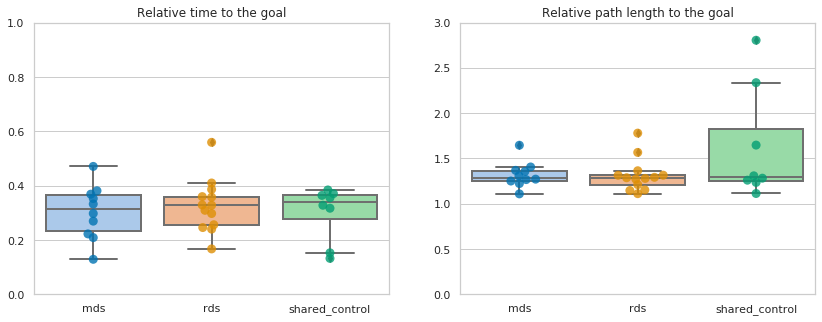

In [28]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(14, 5))

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    catogory='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    catogory='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

plt.show()

In [29]:
plt.close()

### Shared control-related metrics

In [30]:
control_metrics = ('rel_jerk', 
                   'avg_fluency',  
                   'contribution', 
                   'avg_agreement',
                   'path_lenth2goal',
                   'min_dist2goal',
                   )

control_frames = []

for ii, eval_dir in enumerate(eval_dirs):

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    cm_dict = {'seq': eval_database.seqs}
    cm_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    cm_dict.update({k: [] for k in control_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        qolo_eval_npy = os.path.join(eval_res_dir, seq + "_qolo_eval.npy")
        qolo_eval_dict = np.load(
            qolo_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(control_metrics):
            cm_dict[control_metrics[iidx]].append(qolo_eval_dict[val])
        
    # print(cm_dict)
    control_df = pd.DataFrame(cm_dict)
    control_df.columns = ['seq', 'control_type'] + list(control_metrics)
    
    # Filter path_lenth2goal less than 5 meter
    control_df = control_df[control_df.path_lenth2goal >= 5.0]

    control_frames.append(control_df)
    
control_metrics_df = pd.concat(control_frames, ignore_index=True)

Reading results from 0410_mds
Reading results from 0410_rds
Reading results from 0410_shared_control


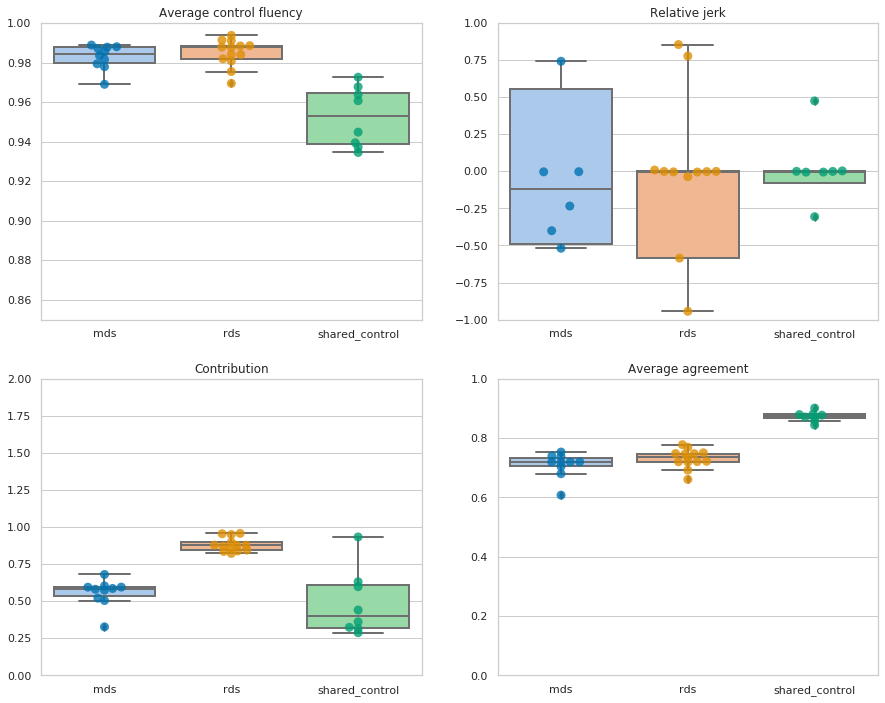

In [31]:
control_fig, control_axes = plt.subplots(2, 2, figsize=(15, 12))

categorical_plot(
    axes=control_axes[0,0],
    df=control_metrics_df,
    metric='avg_fluency',
    catogory='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.85, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[0,1],
    df=control_metrics_df,
    metric='rel_jerk',
    catogory='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[-1.0, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,0],
    df=control_metrics_df,
    metric='contribution',
    catogory='control_type',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 2.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,1],
    df=control_metrics_df,
    metric='avg_agreement',
    catogory='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    # lgd_labels=['Not reached', 'Reached'],
    # group='goal_reached',
    kind='box',
)

plt.show()

In [32]:
plt.close()

## Comparison between 0410 and 0424

In [33]:
example_dates = ['0410', '0424']
eval_dirs = []
for root, dirs, files in walk(bagbase, topdown=False, maxdepth=1):
    for dir in dirs:
        for date in example_dates:
            if (date in dir):
                eval_dirs.append(dir)
                print("{}/ is available!".format(dir))

0410_mds/ is available!
0410_rds/ is available!
0410_shared_control/ is available!
0424_mds/ is available!
0424_rds/ is available!
0424_shared_control/ is available!


### Crowd-related metrics

In [34]:
crowd_metrics = ('avg_crowd_density5', 
                 'max_crowd_density5', 
                 'avg_crowd_density10', 
                 'avg_min_dist',
                 'normalized_proximity',
                 'path_lenth2goal',
                 'min_dist2goal',
                )

frames = []

for eval_dir in eval_dirs:
    
    # extract date
    date = eval_dir[:4]

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    m_dict = {'seq': eval_database.seqs}
    m_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    m_dict.update({k: [] for k in crowd_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        crowd_eval_npy = os.path.join(eval_res_dir, seq + "_crowd_eval.npy")
        crowd_eval_dict = np.load(
            crowd_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(crowd_metrics):
            m_dict[crowd_metrics[iidx]].append(crowd_eval_dict[val])

    crowd_df = pd.DataFrame(m_dict)
    crowd_df.columns = ['seq', 'control_type'] + list(crowd_metrics)
    
    # Filter path_lenth2goal less than 5 meter
    crowd_df = crowd_df[crowd_df.path_lenth2goal >= 5.0]
    # add date col
    crowd_df['date'] = [date] * len(crowd_df)

    frames.append(crowd_df)

crowd_metrics_df = pd.concat(frames, ignore_index=True)

Reading results from 0410_mds
Reading results from 0410_rds
Reading results from 0410_shared_control
Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


In [35]:
for ctrl in control_types:
    print("###", ctrl)
    print("# mean")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].mean(numeric_only=True))
    print("# std")
    print(crowd_metrics_df[crowd_metrics_df.control_type == ctrl].std(numeric_only=True))
    print()

### mds
# mean
avg_crowd_density5       0.116808
max_crowd_density5       0.269768
avg_crowd_density10      0.064746
avg_min_dist             1.167190
normalized_proximity     0.000000
path_lenth2goal         21.510727
min_dist2goal            4.836644
dtype: float64
# std
avg_crowd_density5      0.018398
max_crowd_density5      0.038680
avg_crowd_density10     0.007422
avg_min_dist            0.164013
normalized_proximity    0.000000
path_lenth2goal         5.901876
min_dist2goal           3.985879
dtype: float64

### rds
# mean
avg_crowd_density5       0.126946
max_crowd_density5       0.284569
avg_crowd_density10      0.066589
avg_min_dist             1.021875
normalized_proximity     0.000000
path_lenth2goal         20.205347
min_dist2goal            6.877405
dtype: float64
# std
avg_crowd_density5       0.020605
max_crowd_density5       0.053587
avg_crowd_density10      0.005375
avg_min_dist             0.191384
normalized_proximity     0.000000
path_lenth2goal          6.205538
m

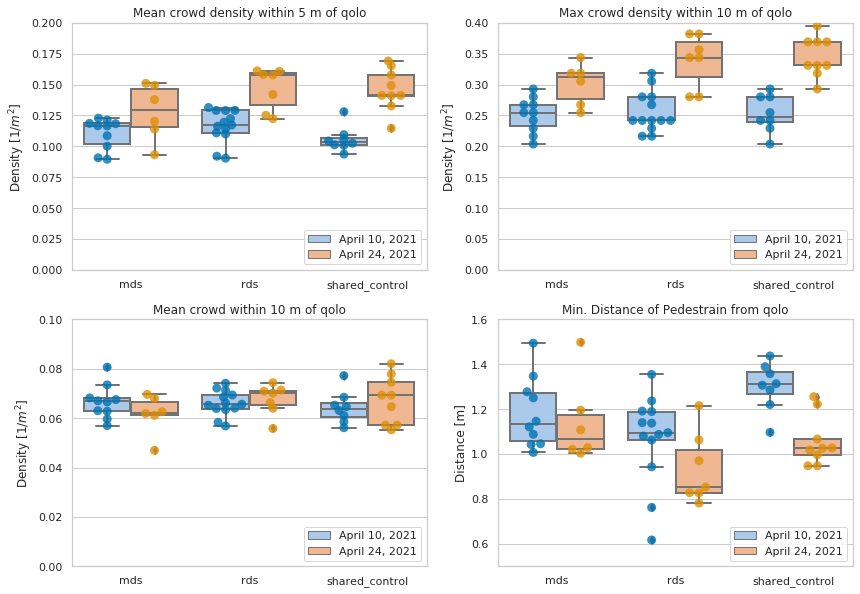

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categorical_plot(
    axes=axes[0,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density5',
    catogory='control_type',
    title='Mean crowd density within 5 m of qolo',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.20],
    kind='box',
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
)
categorical_plot(
    axes=axes[0,1],
    df=crowd_metrics_df,
    metric='max_crowd_density5',
    catogory='control_type',
    title='Max crowd density within 10 m of qolo',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.40],
    kind='box',
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
)

categorical_plot(
    axes=axes[1,0],
    df=crowd_metrics_df,
    metric='avg_crowd_density10',
    catogory='control_type',
    title='Mean crowd within 10 m of qolo',
    xlabel='',
    ylabel='Density [1/$m^2$]',
    ylim=[0.0, 0.1],
    kind='box',
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
)

categorical_plot(
    axes=axes[1,1],
    df=crowd_metrics_df,
    metric='avg_min_dist',
    catogory='control_type',
    title='Min. Distance of Pedestrain from qolo',
    xlabel='',
    ylabel='Distance [m]',
    ylim=[0.5, 1.6],
    kind='box',
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
)

plt.show()

In [37]:
plt.close()

### Path Efficiency-related metrics

In [38]:
path_metrics = ('rel_duration2goal', 
                'rel_path_length2goal', 
                'path_lenth2goal',
                'duration2goal',
                'min_dist2goal',
               )

path_frames = []

for ii, eval_dir in enumerate(eval_dirs):
    
    # extract date
    date = eval_dir[:4]

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    pm_dict = {'seq': eval_database.seqs}
    pm_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    pm_dict.update({k: [] for k in path_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        qolo_eval_npy = os.path.join(eval_res_dir, seq + "_qolo_eval.npy")
        qolo_eval_dict = np.load(
            qolo_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(path_metrics):
            pm_dict[path_metrics[iidx]].append(qolo_eval_dict[val])
        
    path_df = pd.DataFrame(pm_dict)
    path_df.columns = ['seq', 'control_type'] + list(path_metrics)
    
    # Filter path_lenth2goal less than 5 meter
    path_df = path_df[path_df.path_lenth2goal >= 5.0]
    # add date col
    path_df['date'] = [date] * len(path_df)

    path_frames.append(path_df)
    
path_metrics_df = pd.concat(path_frames, ignore_index=True)
path_metrics_df.head()

Reading results from 0410_mds
Reading results from 0410_rds
Reading results from 0410_shared_control
Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


,seq,control_type,rel_duration2goal,rel_path_length2goal,path_lenth2goal,duration2goal,min_dist2goal,date
0,2021-04-10-11-28-10,mds,0.222623,1.223539,18.637169,85.526728,4.849555,0410
1,2021-04-10-11-30-57,mds,0.368713,1.307549,20.382484,52.847092,4.291679,0410
2,2021-04-10-11-33-46,mds,0.470863,1.109684,18.319101,43.824839,3.306577,0410
3,2021-04-10-11-36-41,mds,0.208948,1.356465,19.928324,87.888817,5.038430,0410
4,2021-04-10-11-54-34,mds,0.129141,1.646356,10.646132,62.591449,13.975889,0410


/home/crowdbot/miniconda3/envs/py38cuda110/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


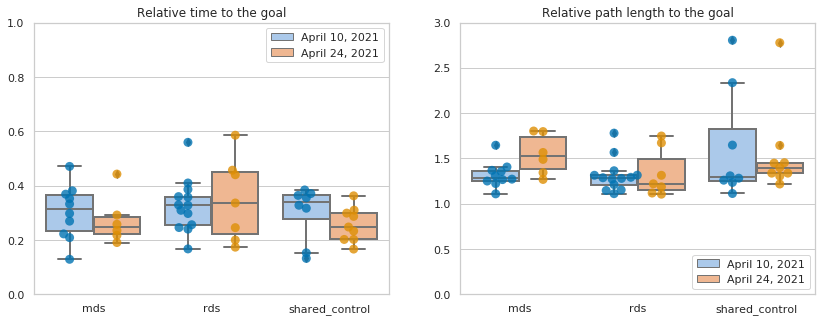

In [39]:
path_fig, path_axes = plt.subplots(1, 2, figsize=(14, 5))

categorical_plot(
    axes=path_axes[0],
    df=path_metrics_df,
    metric='rel_duration2goal',
    catogory='control_type',
    title='Relative time to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=path_axes[1],
    df=path_metrics_df,
    metric='rel_path_length2goal',
    catogory='control_type',
    title='Relative path length to the goal',
    xlabel='',
    ylabel='',
    ylim=[0.0, 3.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    kind='box',
)

plt.show()

In [40]:
plt.close()

### Shared control-related metrics

In [41]:
control_metrics = ('rel_jerk', 
                   'avg_fluency',  
                   'contribution', 
                   'avg_agreement',
                   'path_lenth2goal',
                   'min_dist2goal',
                   )

control_frames = []

for ii, eval_dir in enumerate(eval_dirs):
    
    # extract date
    date = eval_dir[:4]

    print("Reading results from {}".format(eval_dir))

    # new a CrowdBotDatabase() instance
    eval_database = CrowdBotDatabase(classdir=eval_dir)

    cm_dict = {'seq': eval_database.seqs}
    cm_dict.update(
        {'control_type': [eval_dir[5:] for i in range(eval_database.nr_seqs())]}
    )
    cm_dict.update({k: [] for k in control_metrics})

    for idx, seq in enumerate(eval_database.seqs):
        eval_res_dir = os.path.join(eval_database.metrics_dir)
        qolo_eval_npy = os.path.join(eval_res_dir, seq + "_qolo_eval.npy")
        qolo_eval_dict = np.load(
            qolo_eval_npy,
            allow_pickle=True,
        ).item()

        for iidx, val in enumerate(control_metrics):
            cm_dict[control_metrics[iidx]].append(qolo_eval_dict[val])
        
    # print(cm_dict)
    control_df = pd.DataFrame(cm_dict)
    control_df.columns = ['seq', 'control_type'] + list(control_metrics)
    
    # Filter path_lenth2goal less than 5 meter
    control_df = control_df[control_df.path_lenth2goal >= 5.0]
    # add date col
    control_df['date'] = [date] * len(control_df)

    control_frames.append(control_df)
    
control_metrics_df = pd.concat(control_frames, ignore_index=True)

Reading results from 0410_mds
Reading results from 0410_rds
Reading results from 0410_shared_control
Reading results from 0424_mds
Reading results from 0424_rds
Reading results from 0424_shared_control


In [42]:
def categorical_plot(
    axes,
    df,
    metric,
    catogory,
    title,
    xlabel,
    ylabel,
    ylim,
    group=None,
    lgd_labels=None,
    loc='lower right',
    kind='violin',
):

    sns.set_theme(style="whitegrid")

    # fmt: off 
    # use stripplot instead of swarmplot to handle many datapoints
    sns.stripplot(x=catogory, y=metric, hue=group, data=df, ax=axes,
                  size=8, alpha=0.75, palette="colorblind",
                  edgecolor='black', dodge=True,
                 )
    if kind == 'violin':
        sns.violinplot(x=catogory, y=metric, hue=group, data=df, ax=axes,
                       linewidth=1.1, notch=False, orient="v",
                       dodge=True, palette="pastel", inner=None,
                      )
    elif kind == 'box':
        sns.boxplot(x=catogory, y=metric, hue=group, data=df, ax=axes,
                    linewidth=2, notch=False, orient="v",
                    dodge=True, palette="pastel",
                   )

    # sns.despine(trim=True)

    # fmt: on
    axes.yaxis.grid(True)

    if group:
        # deduplicate labels
        # method1: https://stackoverflow.com/a/33440601/7961693
        # hand, labl = ax.get_legend_handles_labels()
        # plt.legend(np.unique(labl))

        # method2: https://stackoverflow.com/a/33424628/7961693
        lablout, handout = [], []
        hand, labl = axes.get_legend_handles_labels()
        for h, l in zip(hand, labl):
            if l not in lablout:
                lablout.append(l)
                handout.append(h)
        if lgd_labels:
            axes.legend(handles=handout, labels=lgd_labels, loc=loc)
        else:
            axes.legend(handles=handout, labels=lablout, loc=loc)

    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_ylim(bottom=ylim[0], top=ylim[1])

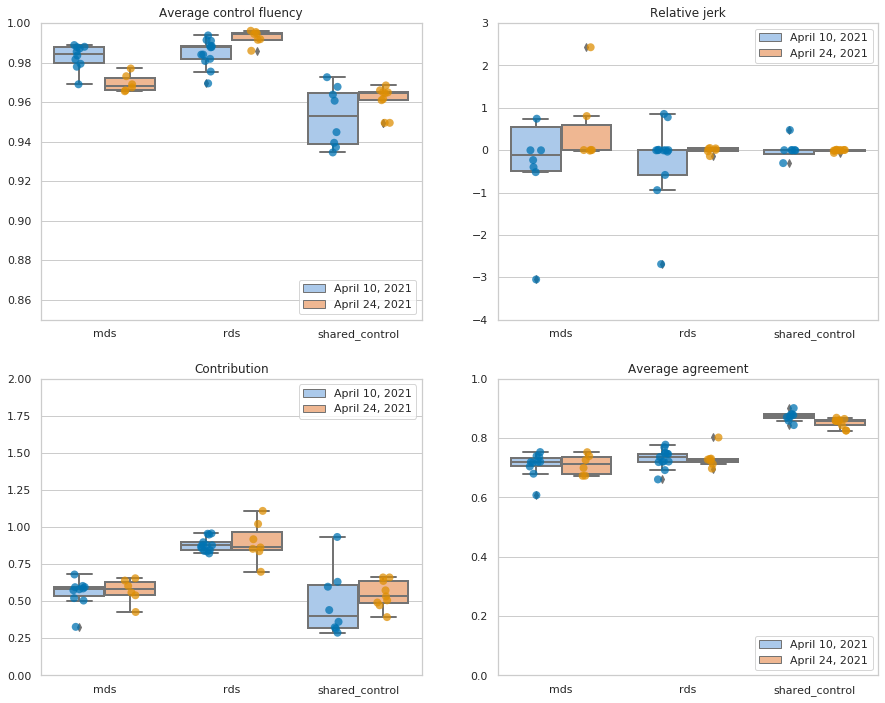

In [43]:
control_fig, control_axes = plt.subplots(2, 2, figsize=(15, 12))

categorical_plot(
    axes=control_axes[0,0],
    df=control_metrics_df,
    metric='avg_fluency',
    catogory='control_type',
    title='Average control fluency',
    xlabel='',
    ylabel='',
    ylim=[0.85, 1.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    kind='box',
)

categorical_plot(
    axes=control_axes[0,1],
    df=control_metrics_df,
    metric='rel_jerk',
    catogory='control_type',
    title='Relative jerk',
    xlabel='',
    ylabel='',
    ylim=[-4.0, 3.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,0],
    df=control_metrics_df,
    metric='contribution',
    catogory='control_type',
    title='Contribution',
    xlabel='',
    ylabel='',
    ylim=[0.0, 2.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    loc='upper right',
    kind='box',
)

categorical_plot(
    axes=control_axes[1,1],
    df=control_metrics_df,
    metric='avg_agreement',
    catogory='control_type',
    title='Average agreement',
    xlabel='',
    ylabel='',
    ylim=[0.0, 1.0],
    lgd_labels=['April 10, 2021', 'April 24, 2021'],
    group='date',
    kind='box',
)

plt.show()

In [44]:
plt.close()